The goal of this notebook is to classify the different aerodigestive sites.

This was motivated by Charlson et al: "Bacterial communities from the lung displayed composition indistinguishable from the upper airways, but were 2 to 4 logs lower in biomass," based on six patients.

Note that the later Bassis et al. which also had more patients did not make such a bold claim. 

In [1]:
import pandas as pd
import numpy as np

from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import auc, roc_curve, confusion_matrix
from scipy import interp
from scipy.stats import fisher_exact

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Raw data
fnotu = '/Users/claire/github/aspiration-analysis/data/clean/rosen.otu_table.rel_abun.clean'
fnmeta = '/Users/claire/github/aspiration-analysis/data/clean/rosen.metadata.clean'

df = pd.read_csv(fnotu, sep='\t', index_col=0)
meta = pd.read_csv(fnmeta, sep='\t', index_col=0)

meta.head()

,"If Yes, specify the symptom score","If yes, please indicate level",% time pH<4,% time pH<4:,A1. Subject ID number:,A2. Subject initials:,A3. What Cohort is the subject enrolled into?,A4. Aim(s) enrolled in?,A5. Date of initial/baseline visit/procedure (MM/DD/YYYY):,A5a. Date filled out(MM/DD/YYYY):,...,STUDYID,STUDY,AIM,SOURCE,PHMII,ACIDSUP,DATE,ppi_consolidated,mbs_consolidated,total_reads
01-112-7GI,NaN,NaN,NaN,n/a,01-112-7,DM,GERD,Aim 1,2014-04-14,2014-04-14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,271980
01-112-7RI,NaN,NaN,NaN,n/a,01-112-7,DM,GERD,Aim 1,2014-04-14,2014-04-14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,244891
01-112-7TI,NaN,NaN,NaN,n/a,01-112-7,DM,GERD,Aim 1,2014-04-14,2014-04-14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41988
01-164-7GI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89821
01-164-7RI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72671


We need to make sure that each person's samples are in the same train or test set. Otherwise, we'll get really good classification of the person (rather than the site)

Pseudo-code:
- for each site comparisons, get all the patients with both sites
- split those patients into test and train sets (k-fold cross validation)
- for each training fold:
    - get the samples corresponding to the patients in the train (and test) sets
    - train and test
    - report results

In [3]:
site1 = 'bal'
site2 = 'gastric_fluid'

meta.query('(site == @site1) | (site == @site2)').shape

(312, 958)

In [4]:
## Step-by-step operations in commentd cells below
#nperpatient = meta.query('(site == @site1) | (site == @site2)').groupby('subject_id').size().to_frame(name='n_samples')
#nperpatient.head()

In [5]:
## 1. get only samples from sites of interest
## 2. Groupby subject and site, to get the number of samples per site that each patient has
##    Some patients have 2 gastric samples, for example, so just grouping by subject isn't
##    what we want.
## 3. Reset index to get dataframe with subject_id, site, number of samples
## 4. Now groupby subject_id again, to get the number of sites that patient has
#nperpatient = meta\
#    .query('(site == @site1) | (site == @site2)')\
#    .groupby(['subject_id', 'site'])\
#    .size()\
#    .reset_index()\
#    .groupby('subject_id')\
#    .size()

In [6]:
#nperpatient[nperpatient['n_samples'] == 2].shape

In [7]:
#subjects = nperpatient[nperpatient['n_samples'] == 2].index.tolist()[0:10]
#subjects

In [8]:
## Get the samples that are either site1 or site2 from the desired patients!
#meta.query('((site == @site1) | (site == @site2)) & (subject_id == @subjects)').shape

In [9]:
#samples = meta.query('((site == @site1) | (site == @site2)) & (subject_id == @subjects)').index.tolist()
#samples

In [10]:
def get_subjects(meta, site1, site2):
    """
    Get the subjects from meta which have both site1 and site2 samples.
    """
    # 1. get only samples from sites of interest
    # 2. Groupby subject and site, to get the number of samples per site that each patient has
    #    Some patients have 2 gastric samples, for example, so just grouping by subject isn't
    #    what we want.
    # 3. Reset index to get dataframe with subject_id, site, number of samples
    # 4. Now groupby subject_id again, to get the number of sites that patient has
    nperpatient = meta\
        .query('(site == @site1) | (site == @site2)')\
        .groupby(['subject_id', 'site'])\
        .size()\
        .reset_index()\
        .groupby('subject_id')\
        .size()\
        .to_frame(name='n_samples')

    return nperpatient[nperpatient['n_samples'] == 2].index

def get_samples(meta, subjs, s1, s2):
    """
    Get samples from meta corresponding to sites 1 and 2 from
    subjects in subjs
    
    Parameters
    ----------
    meta : pandas DataFrame
        has columns 'subject_id' and 'site'
    subjs : list
        subjects in meta['subject_id'] to return samples for
    s1, s2 : str
        sites in meta['site'] to return samples for
    
    Returns
    -------
    pandas Index
    """
    return meta.query('((site == @s1) | (site == @s2)) & (subject_id == @subjs)').index

In [14]:
def subject_wise_classify(meta, subjects, site1, site2, n_folds=10, random_state=12345):
    """
    Make one subject-wise classifier to distinguish the two sites.
    
    Parameters
    ----------
    meta : pandas DataFrame
        has columns 'site' and 'subject_id'
    subjects : pandas Index (or list)
        subjects in meta['subject_id'] to use samples from
    site1, site2 : str
        sites to use samples from
    n_folds, random_state : int
        RandomForestClassifier parameters
    
    Returns
    -------
    sample_results : pandas DataFrame
        samples in index, columns ['true', 'pred', 'prob', 'cvfold']
    conf_mat, mean_tpr, mean_fpr : array/list-like
        interpolated results from cross-validation testing
    """

    # Prepare empty lists for storing classification performance
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    conf_mat = np.asarray([[0,0],[0,0]])

    # Prepare dataframe to store sample-wise results
    all_samples = get_samples(meta, subjects.tolist(), site1, site2)
    sample_results = pd.DataFrame(
        index=all_samples, columns=['true', 'pred', 'prob', 'cvfold'])
    cv_count = 0

    # Prepare cross-validation folds
    kf = KFold(len(subjects), n_folds=n_folds, shuffle=True)

    # These indices are indices for the subjects list
    for train_index, test_index in kf:
        print(cv_count)
        ## Prepare the training and test data
        # Get the samples corresponding to the train/test subjects
        train_subjects = subjects[train_index].tolist()
        test_subjects = subjects[test_index].tolist()

        train_samples = get_samples(meta, train_subjects, site1, site2)
        test_samples = get_samples(meta, test_subjects, site1, site2)

        # Set up X and Y
        x_train = df.loc[train_samples]
        x_test = df.loc[test_samples]

        # site1 is label 0, site 2 is label 1
        y_train = (meta.loc[train_samples, 'site'] == site2).astype(int).values
        y_test = (meta.loc[test_samples, 'site'] == site2).astype(int).values

        ## Classify
        rf = RandomForestClassifier(n_estimators=1000, random_state=random_state)
        rf = rf.fit(x_train, y_train)

        ## Store the sample-wise results
        sample_results.loc[test_samples, 'true'] = y_test
        probs = rf.fit(x_train, y_train).predict_proba(x_test)[:,1]
        sample_results.loc[test_samples, 'prob'] = probs
        y_pred = rf.predict(x_test)
        sample_results.loc[test_samples, 'pred'] = y_pred
        sample_results.loc[test_samples, 'cvfold'] = cv_count
        cv_count += 1

        ## Store classifier performance results
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y_test, probs)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        # Compute confusion matrix
        conf_mat += confusion_matrix(y_test, y_pred, labels=[0,1])

    mean_tpr /= len(kf)
    roc_auc = auc(mean_fpr, mean_tpr) 
    
    return sample_results, conf_mat, mean_tpr, mean_fpr, roc_auc

('bal', 'gastric_fluid')
0
1
2
3
4
0.790837771656
('bal', 'throat_swab')
0
1
2
3
4
0.972623899817
('gastric_fluid', 'throat_swab')
0
1
2
3
4
0.93956095345
('throat_swab', 'stool')
0
1
2
3
4
1.0


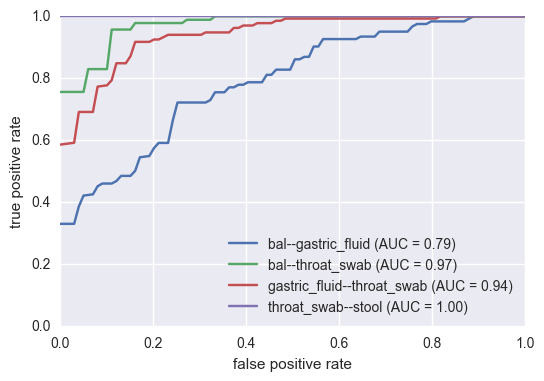

In [16]:
sites = ['bal', 'gastric_fluid', 'throat_swab', 'rectal_swab', 'stool']
n_folds = 5
random_state = 12453

for site1 in sites:
    for site2 in sites[sites.index(site1)+1:]:
        subjects = get_subjects(meta, site1, site2)
        if len(subjects) > 5*n_folds:
            print(site1, site2)
            res = subject_wise_classify(meta, subjects, site1, site2, n_folds=5)
            plt.plot(res[3], res[2], 
                     label=site1 + '--' + site2 + ' (AUC = {:.2f})'.format(res[4]))
            print(auc(res[3], res[2]))
plt.axis([0, 1, 0, 1])
plt.legend(loc='lower right')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')


Interesting, these results tell me two things:
1. The aerodigestive communities are definitely distinct
    - could try to prove this with less sensitive classifiers? RFs are so good at what they do...
2. BAL and gastric fluid seem more similar than we'd expect.
    - Not entirely sure why they're harder to distinguish than throat and gastric fluid though...
   
Next: look at features for these classifiers. 

Hypothesis: the throat/gastric combination has some bugs which are only present in one of the sites, but the bal/gastric doesn't and so that's why it's harder to distinguish.

## Investigate features


In [128]:
sites = ['bal', 'gastric_fluid', 'throat_swab', 'rectal_swab', 'stool']
n_folds = 5
random_state = 12453

all_feats = []
# Train classifiers on all of the data, look at features
for site1 in sites:
    for site2 in sites[sites.index(site1)+1:]:
        subjects = get_subjects(meta, site1, site2)
        if len(subjects) > 5*n_folds:
            all_samples = get_samples(meta, subjects.tolist(), site1, site2)

            # Set up X and Y
            x = df.loc[all_samples]

            # site1 is label 0, site 2 is label 1
            y = (meta.loc[all_samples, 'site'] == site2).astype(int).values

            ## Classify
            rf = RandomForestClassifier(n_estimators=1000, random_state=random_state)
            rf = rf.fit(x, y)

            # Extract features
            fts = pd.DataFrame({'features': x.columns, 'importance': rf.feature_importances_})
            fts['rel_importance'] = feats['importance']/feats['importance'].max()
            fts['classifier'] = site1 + '--' + site2
            all_feats.append(fts)

In [164]:
features = pd.concat(all_feats)
features.head()

,features,importance,rel_importance,classifier
0,k__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.001760,0.114826,bal--gastric_fluid
1,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.000000,0.000000,bal--gastric_fluid
2,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.001926,0.125634,bal--gastric_fluid
3,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.000351,0.022925,bal--gastric_fluid
4,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.000000,0.000000,bal--gastric_fluid


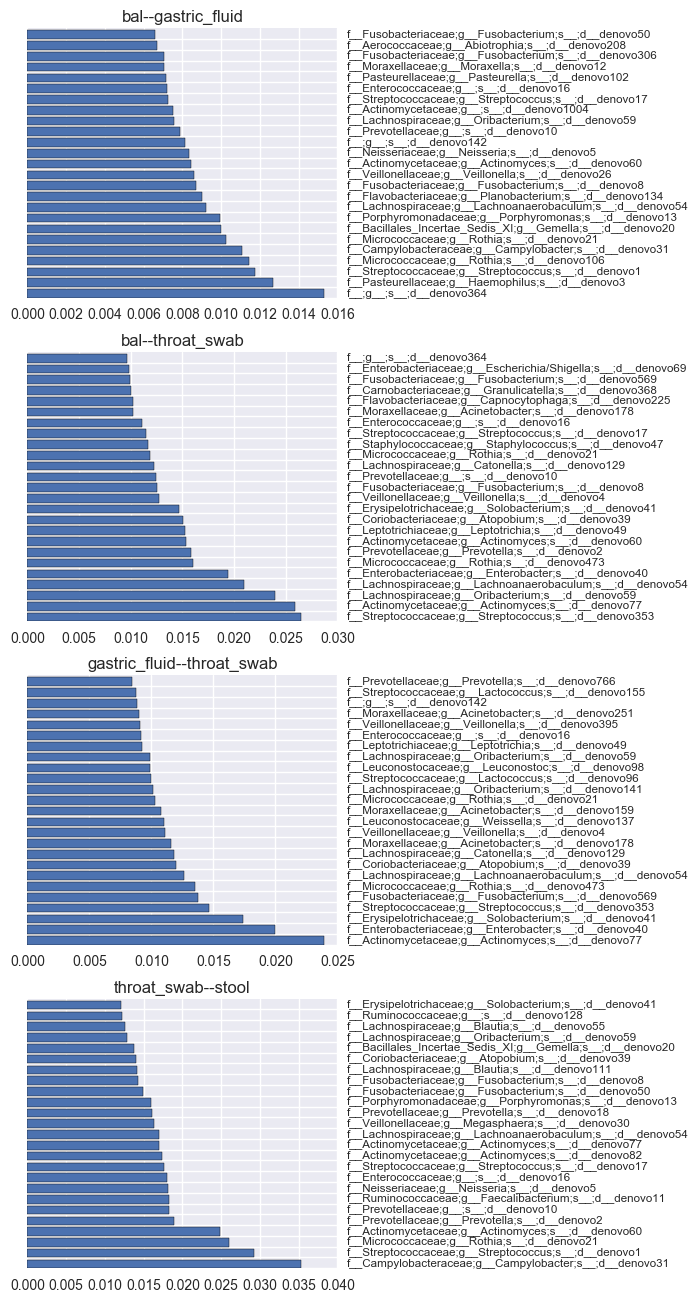

In [148]:
N = 25
fig, ax = plt.subplots(4, 1, figsize=(4, 16))
i = 0
for g, subdf in features.groupby('classifier'):
    subdf = subdf.sort_values(by='importance', ascending=False)
    subdf['short_otu'] = subdf['features'].str.split(';', 4).str[-1]
    # Plot
    ax[i].barh(np.arange(0,N), subdf['importance'][:N])
    ax[i].yaxis.tick_right()
    ax[i].yaxis.set_label_position('right')
    ax[i].set_yticks(np.arange(0,N))
    ax[i].set_yticklabels(subdf['short_otu'][:N], fontsize='small', va='bottom')
    ax[i].set_title(g)
    i += 1

Looks like the top five features are most informative in most of the classifiers. Let's look at the abundances of these features!

In [177]:
# Make longform OTU table with OTU, abundance, sample, site columns
df.index.name = 'sample'
longdf = pd.melt(df.reset_index(), id_vars='sample', var_name='otu', value_name='abundance')
longdf = longdf.join(meta['site'], on='sample')
longdf['log10abun'] = np.log10(longdf['abundance'] + 1e-7)
longdf['short_otu'] = longdf['otu'].str.split(';', 4).str[-1]
longdf.head()

,sample,otu,abundance,site,log10abun,short_otu
0,01-112-7GI,k__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.025428,gastric_fluid,-1.594680,f__Acidaminococcaceae;g__Phascolarctobacterium...
1,01-112-7RI,k__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.013573,rectal_swab,-1.867309,f__Acidaminococcaceae;g__Phascolarctobacterium...
2,01-112-7TI,k__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.000000,throat_swab,-7.000000,f__Acidaminococcaceae;g__Phascolarctobacterium...
3,01-164-7GI,k__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.000011,gastric_fluid,-4.949494,f__Acidaminococcaceae;g__Phascolarctobacterium...
4,01-164-7RI,k__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.010651,rectal_swab,-1.972616,f__Acidaminococcaceae;g__Phascolarctobacterium...


In [188]:
def plot_top_N_feat_abun(meta, site1, site2, longdf, features, N):
    cls = site1 + '--' + site2
    subjects = get_subjects(meta, site1, site2)
    all_samples = get_samples(meta, subjects.tolist(), site1, site2).tolist()

    # Just get the right samples
    toplot = longdf.query('((site == @site1) | (site == @site2)) & (sample == @all_samples)')
    # Now pick the top five features
    otus = features\
        .query('classifier == @cls')\
        .sort_values(by='importance', ascending=False)\
        ['features'][:N]\
        .tolist()
    toplot = toplot.query('otu == @otus')
    #toplot['sample'].unique().shape
    g = sns.FacetGrid(data=toplot, col='short_otu')
    g.map(sns.boxplot, 'site', 'log10abun')
    g.map(sns.stripplot, 'site', 'log10abun', jitter=True, linewidth=0.5)

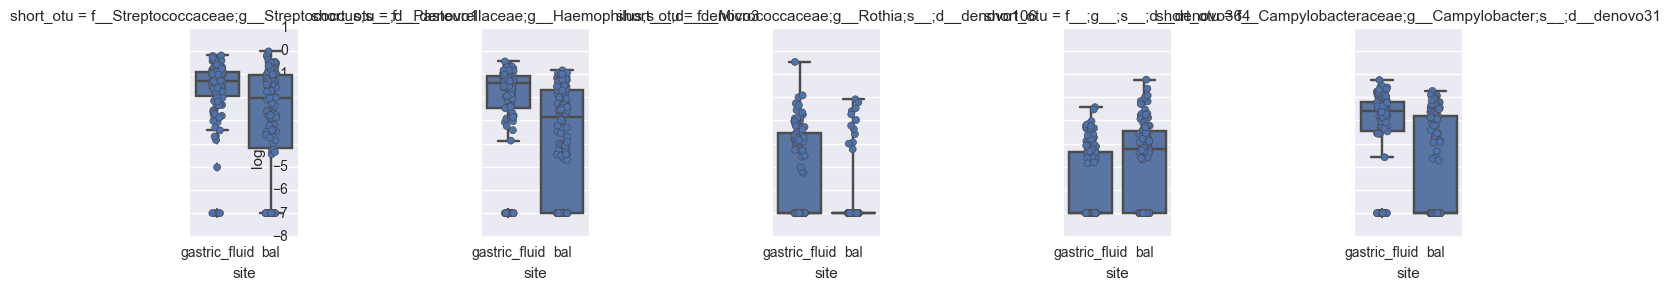

In [189]:
# Plot abundances of top 5 features between sites
site1 = 'bal'
site2 = 'gastric_fluid'
plot_top_N_feat_abun(meta, site1, site2, longdf, features, 5)

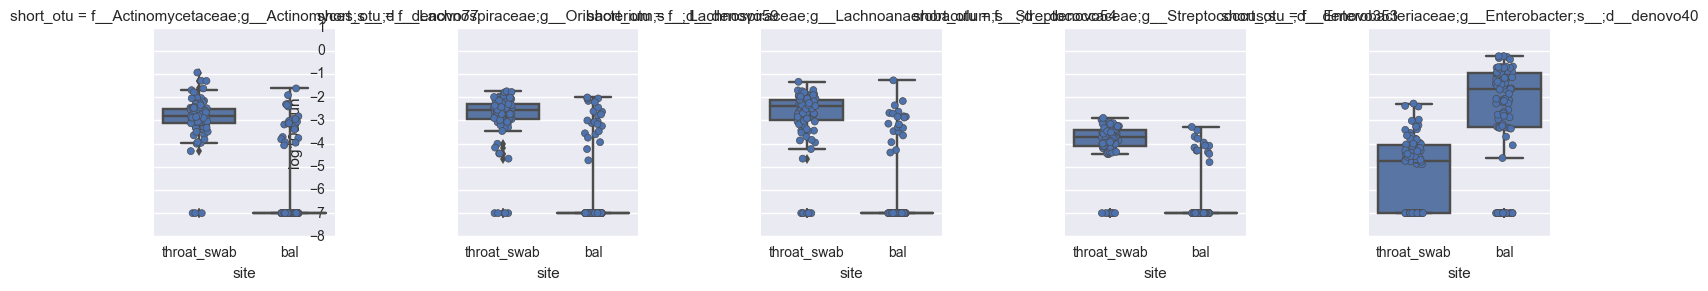

In [190]:
site1 = 'bal'
site2 = 'throat_swab'
plot_top_N_feat_abun(meta, site1, site2, longdf, features, 5)

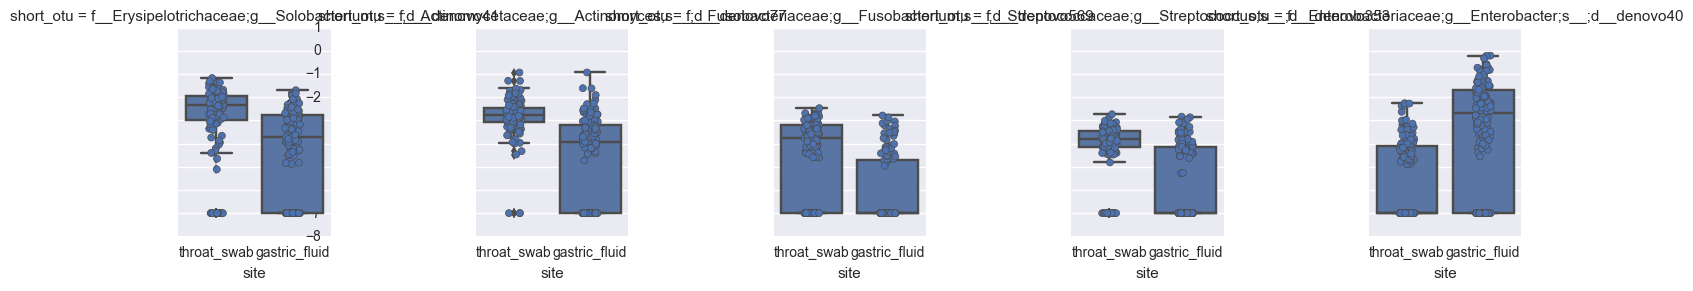

In [191]:
site1 = 'gastric_fluid'
site2 = 'throat_swab'
plot_top_N_feat_abun(meta, site1, site2, longdf, features, 5)

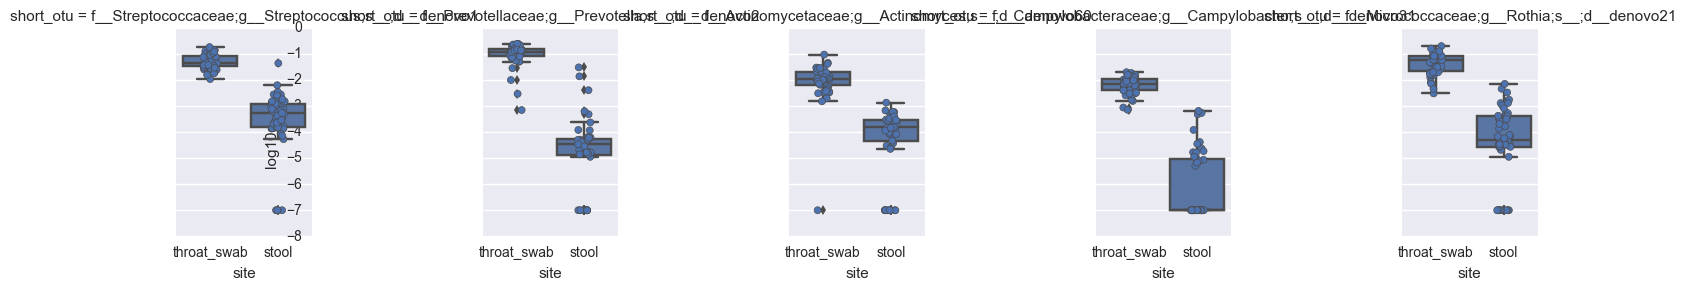

In [192]:
site1 = 'throat_swab'
site2 = 'stool'
plot_top_N_feat_abun(meta, site1, site2, longdf, features, 5)